In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 10})
import matplotlib.cm as cm
import seaborn as sns

import pickle as pkl
from tqdm import tqdm

exec(open("./diagnostics_header.py").read())
import diagnostics_ops as diops
import diagnostics_vars as divars

# -----------------------------------------------------------------

# linestyles list from https://matplotlib.org/gallery/lines_bars_and_markers/linestyles.html
linestyles = [('solid',               (0, ())),
     #('loosely dotted',      (0, (1, 10))),
     #('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     #('loosely dashed',      (0, (5, 10))),
     #('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     #('loosely dashdotted',  (0, (3, 10, 1, 10))),
     #('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     #('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     #('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     ('solid',               (0, ()))]

In [5]:
save = False
dpi=300

# problem parameters
mach_no = 10
omega_frame = 1.0
GM1 = 0.7692307692307692
x1min = 0.05
x1max = 0.62              # maximum value of X1
inflow = -0.01            # radial velocity at L1
inflow_dens = 4.0         # density at L1
inflow_phi = 0.05         # angular half-size of the L1 zone
                          # if -n, L1 diameter set to n times thermal scale height
    
inflow_mdot = -np.pi * (x1max*inflow_phi)**2 * inflow_dens * inflow

# time of start of the steady state
tstart_steady = 2.*np.pi * 20.

# time limits of accretion states
#accretion_state_times = {'A':[15.5, 18.], 'B':[18., 20.5], 'C':[20.5, 23.5], 'D':[23.5,27.], 'E':[27.,29.]}
accretion_state_times = {'A':[34.,39.], 'B':[39., 45.6]}

def state2title (acc_state):
    if acc_state == None or acc_state == 'None':
        return 'steady'
    else:
        return 'state%s' % acc_state

In [6]:
data_pathstem = '/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/'
dataset_pathstem = data_pathstem + 'R5_dfloor1e-6_vfloorRho1e-5/'

output_path = '/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/Paper1/figures/toSend/Mach10/'

In [7]:
# pitch angle from the dispersion relation
def omega_binary ():
    return 1.0

def omega_keplerian (r, phi=0):
    return np.sqrt(GM1)/r**1.5

def tan_pitch (local_mach_no, omega_pattern, omega, m=2):
    return 1. / (local_mach_no * np.sqrt((1.-omega_pattern/omega)**2 - 1./m**2))

def csound_locIsoth (r, phi=0, mach_no=mach_no):
    return (np.sqrt(GM1/x1min) / mach_no) * (x1min/r)**(3./8.)

def mach_locIsoth (r, phi=0, mach_no=mach_no):
    return np.sqrt(GM1/r) / csound_locIsoth(r, mach_no=mach_no)

def find_idx (x, x_table):
    dist = (np.array(x_table) - x)**2
    return np.argmin(dist)

def csound_true (r, phi, ops_obj_eq_csound):
    phi_idx = find_idx(phi % (2.*np.pi), ops_obj_eq_csound.phi)
    r_idx = find_idx(r, ops_obj_eq_csound.r)
    return ops_obj_eq_csound.val[r_idx, phi_idx]

def alfven_true (r, phi, ops_obj_eq_bfield, ops_obj_eq_rho):
    phi_idx = find_idx(phi % (2.*np.pi), ops_obj_eq_bfield.phi)
    r_idx = find_idx(r, ops_obj_eq_bfield.r)
    return ops_obj_eq_bfield.val[r_idx, phi_idx] / np.sqrt(ops_obj_eq_rho.val[r_idx, phi_idx])

def csound_fms (r, phi, ops_obj_eq_bfield, ops_obj_eq_rho, ops_obj_eq_csound):
    return np.sqrt( csound_true(r, phi, ops_obj_eq_csound=ops_obj_eq_csound)**2 + alfven_true(r, phi, ops_obj_eq_bfield=ops_obj_eq_bfield, ops_obj_eq_rho=ops_obj_eq_rho) )

def csound_sms (r, phi, ops_obj_eq_bfield, ops_obj_eq_rho, ops_obj_eq_csound):
    return np.sqrt( csound_true(r, phi, ops_obj_eq_csound=ops_obj_eq_csound)**2 - alfven_true(r, phi, ops_obj_eq_bfield=ops_obj_eq_bfield, ops_obj_eq_rho=ops_obj_eq_rho) )

def vel3_true_raw (r, phi, ops_obj_eq_vel3):
    phi_idx = find_idx(phi % (2.*np.pi), ops_obj_eq_csound.phi)
    r_idx = find_idx(r, ops_obj_eq_csound.r)
    return 1.*ops_obj_eq_vel3.val[r_idx, phi_idx]

def vel3_true (r, phi, ops_obj_eq_vel3):
    vel3 = vel3_true_raw(r, phi, ops_obj_eq_vel3)
    # correct for frame rotation -- vel3 in LAB frame (NOT what we want)
    #r_bary = 1.0 - GM1
    #sq_dist_bary = r**2 + r_bary**2 - 2.*r*r_bary*np.cos(phi)
    #vel3 += omega_frame * (r**2+sq_dist_bary-r_bary**2) / (2.*r)
    # correct for frame rotation -- vel3 in GM1 frame
    vel3 += omega_frame * r
    return vel3

def mach_true (r, phi, ops_obj_eq_vel3, ops_obj_eq_csound):
    return vel3_true(r, phi, ops_obj_eq_vel3) / csound_true(r, phi, ops_obj_eq_csound)

def mach_sms (r, phi, ops_obj_eq_vel3, ops_obj_eq_csound, ops_obj_eq_bfield, ops_obj_eq_rho):
    return vel3_true(r, phi, ops_obj_eq_vel3) / csound_sms(r, phi, ops_obj_eq_csound=ops_obj_eq_csound, ops_obj_eq_bfield=ops_obj_eq_bfield, ops_obj_eq_rho=ops_obj_eq_rho)

def mach_fms (r, phi, ops_obj_eq_vel3, ops_obj_eq_csound, ops_obj_eq_bfield, ops_obj_eq_rho):
    return vel3_true(r, phi, ops_obj_eq_vel3) / csound_fms(r, phi, ops_obj_eq_csound=ops_obj_eq_csound, ops_obj_eq_bfield=ops_obj_eq_bfield, ops_obj_eq_rho=ops_obj_eq_rho)

def omega_true (r, phi, ops_obj_eq_vel3):
    return vel3_true(r, phi, ops_obj_eq_vel3) / r

<Figure size 432x288 with 0 Axes>

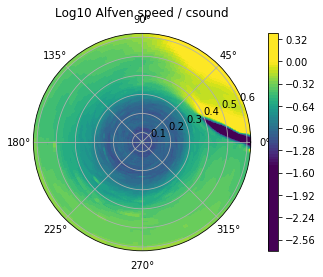

In [5]:
with open(dataset_pathstem + 'steady_rhoSlices.pkl', 'rb') as f:
    ops_obj_eq_rho, _ = pkl.load(f)
with open(dataset_pathstem + 'steady_bfieldSlices.pkl', 'rb') as f:
    ops_obj_eq_bfield, _ = pkl.load(f)
with open(dataset_pathstem + 'steady_csoundSlices.pkl', 'rb') as f:
    ops_obj_eq_csound, _ = pkl.load(f)
    
plt.clf()
fig = plt.figure()

ax = fig.add_subplot(111, projection='polar')
ppp = np.linspace(0, 2.*np.pi, 256)
rrr = np.linspace(0.05, 0.62, 256)
ppp, rrr = np.meshgrid(ppp,rrr)
ppp, rrr = ppp.flatten(), rrr.flatten()
pars = np.array([rrr,ppp]).transpose()
vvv = list(map(lambda x : alfven_true(*x, ops_obj_eq_bfield, ops_obj_eq_rho) / csound_true(*x, ops_obj_eq_csound), pars))
plt.tricontourf(ppp,rrr,np.log10(vvv), vmin=-1.5, vmax=0., levels=100)
plt.colorbar()
plt.title('Log10 Alfven speed / csound')

plt.show()
plt.close()

<Figure size 432x288 with 0 Axes>

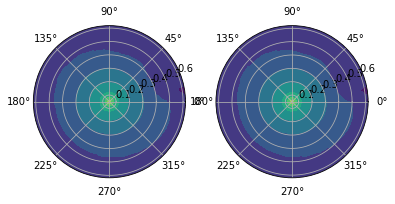

<Figure size 432x288 with 0 Axes>

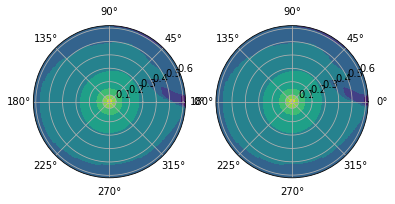

<Figure size 432x288 with 0 Axes>

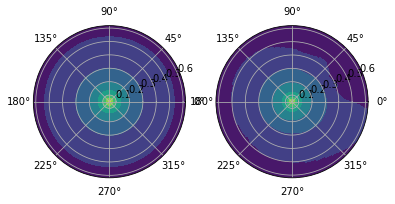

In [6]:
# tests of the readout functions

# read the true equatorial slices of vel3 and csound
with open(dataset_pathstem + 'steady_vel3Slices.pkl', 'rb') as f:
    ops_obj_eq_vel3, _ = pkl.load(f)
with open(dataset_pathstem + 'steady_csoundSlices.pkl', 'rb') as f:
    ops_obj_eq_csound, _ = pkl.load(f)

plt.clf()

fig = plt.figure()

ax = fig.add_subplot(121, projection='polar')
ppp, rrr = np.meshgrid(ops_obj_eq_vel3.phi, ops_obj_eq_vel3.r)
ppp, rrr = ppp.flatten(), rrr.flatten()
plt.tricontourf(ppp, rrr, ops_obj_eq_vel3.val.flatten())

ax = fig.add_subplot(122, projection='polar')
ppp = np.linspace(0, 2.*np.pi, 256)
rrr = np.linspace(0.05, 0.62, 256)
ppp, rrr = np.meshgrid(ppp,rrr)
ppp, rrr = ppp.flatten(), rrr.flatten()
pars = np.array([rrr,ppp]).transpose()
vvv = list(map(lambda x : vel3_true_raw(*x, ops_obj_eq_vel3), pars))
plt.tricontourf(ppp,rrr,vvv)

plt.show()
plt.close()

plt.clf()

fig = plt.figure()

ax = fig.add_subplot(121, projection='polar')
ppp, rrr = np.meshgrid(ops_obj_eq_csound.phi, ops_obj_eq_csound.r)
ppp, rrr = ppp.flatten(), rrr.flatten()
plt.tricontourf(ppp, rrr, ops_obj_eq_csound.val.flatten())

ax = fig.add_subplot(122, projection='polar')
ppp = np.linspace(0, 2.*np.pi, 256)
rrr = np.linspace(0.05, 0.62, 256)
ppp, rrr = np.meshgrid(ppp,rrr)
ppp, rrr = ppp.flatten(), rrr.flatten()
pars = np.array([rrr,ppp]).transpose()
vvv = list(map(lambda x : csound_true(*x, ops_obj_eq_csound), pars))
plt.tricontourf(ppp,rrr,vvv)

plt.show()
plt.close()

plt.clf()

fig = plt.figure()

ax = fig.add_subplot(121, projection='polar')
ppp, rrr = np.meshgrid(ops_obj_eq_vel3.phi, ops_obj_eq_vel3.r)
ppp, rrr = ppp.flatten(), rrr.flatten()
vel_kepl = np.sqrt(GM1/rrr)
plt.tricontourf(ppp, rrr, vel_kepl)

ax = fig.add_subplot(122, projection='polar')
ppp = np.linspace(0, 2.*np.pi, 256)
rrr = np.linspace(0.05, 0.62, 256)
ppp, rrr = np.meshgrid(ppp,rrr)
ppp, rrr = ppp.flatten(), rrr.flatten()
pars = np.array([rrr,ppp]).transpose()
vvv = list(map(lambda x : vel3_true(*x, ops_obj_eq_vel3), pars))
plt.tricontourf(ppp,rrr,vvv)

plt.show()
plt.close()

In [7]:
rmin = 0.05
rmax = 0.20
steps_r = 1000

local_mach_no = 10.

def draw_spiral (phi0, r0=x1min, dr=(x1max-x1min)/steps_r, m=2, omega_pattern=1.0, rmin=x1min, rmax=x1max):
    r = r0; phi=phi0
    phis = [phi,]; rs = [r,]
    
    while r > rmin:
        phi += dr / (r * tan_pitch(mach_locIsoth(r), omega_pattern, omega_keplerian(r), m))
        r -= dr
        phis.append(phi), rs.append(r)
    phis = phis[::-1]
    rs = rs[::-1]
    
    r = r0; phi=phi0
    while r < rmax:
        phi -= dr / (r * tan_pitch(mach_locIsoth(r), omega_pattern, omega_keplerian(r), m))
        r += dr
        phis.append(phi), rs.append(r)
    result = [np.array(rs), np.array(phis)]
    for current_m in range(1, m):
        result.append(np.array(phis)+current_m*2.*np.pi/m)
    return np.array(result)

/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


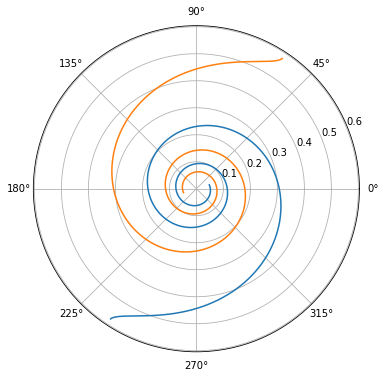

In [8]:
data = draw_spiral(1., 0.1, m=2)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='polar')
for current_m in range(len(data)-1):
    plt.plot(data[1+current_m], data[0])
plt.show()
plt.close()

steady


/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


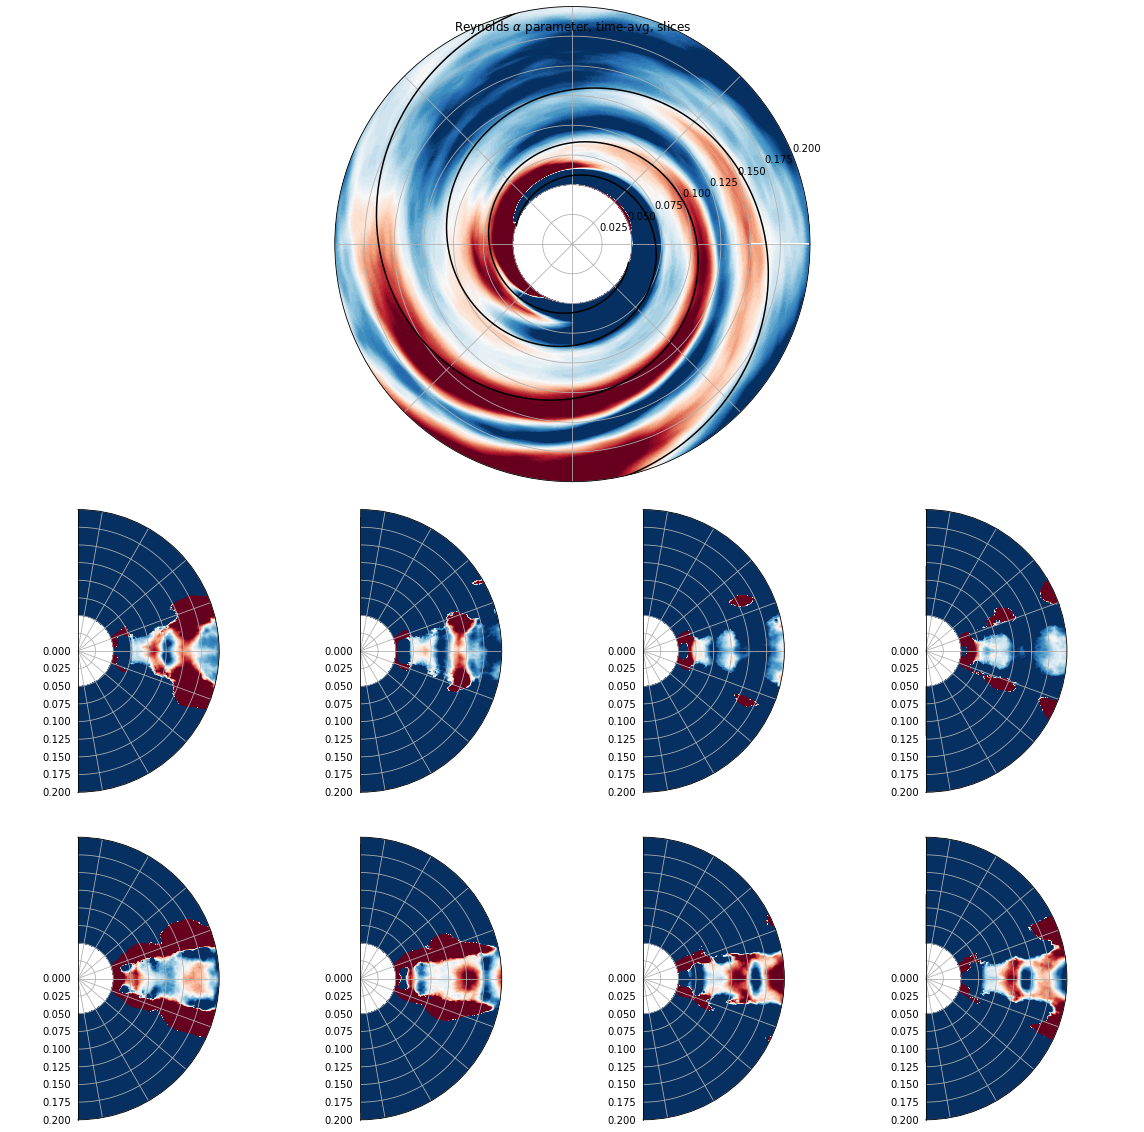

stateA


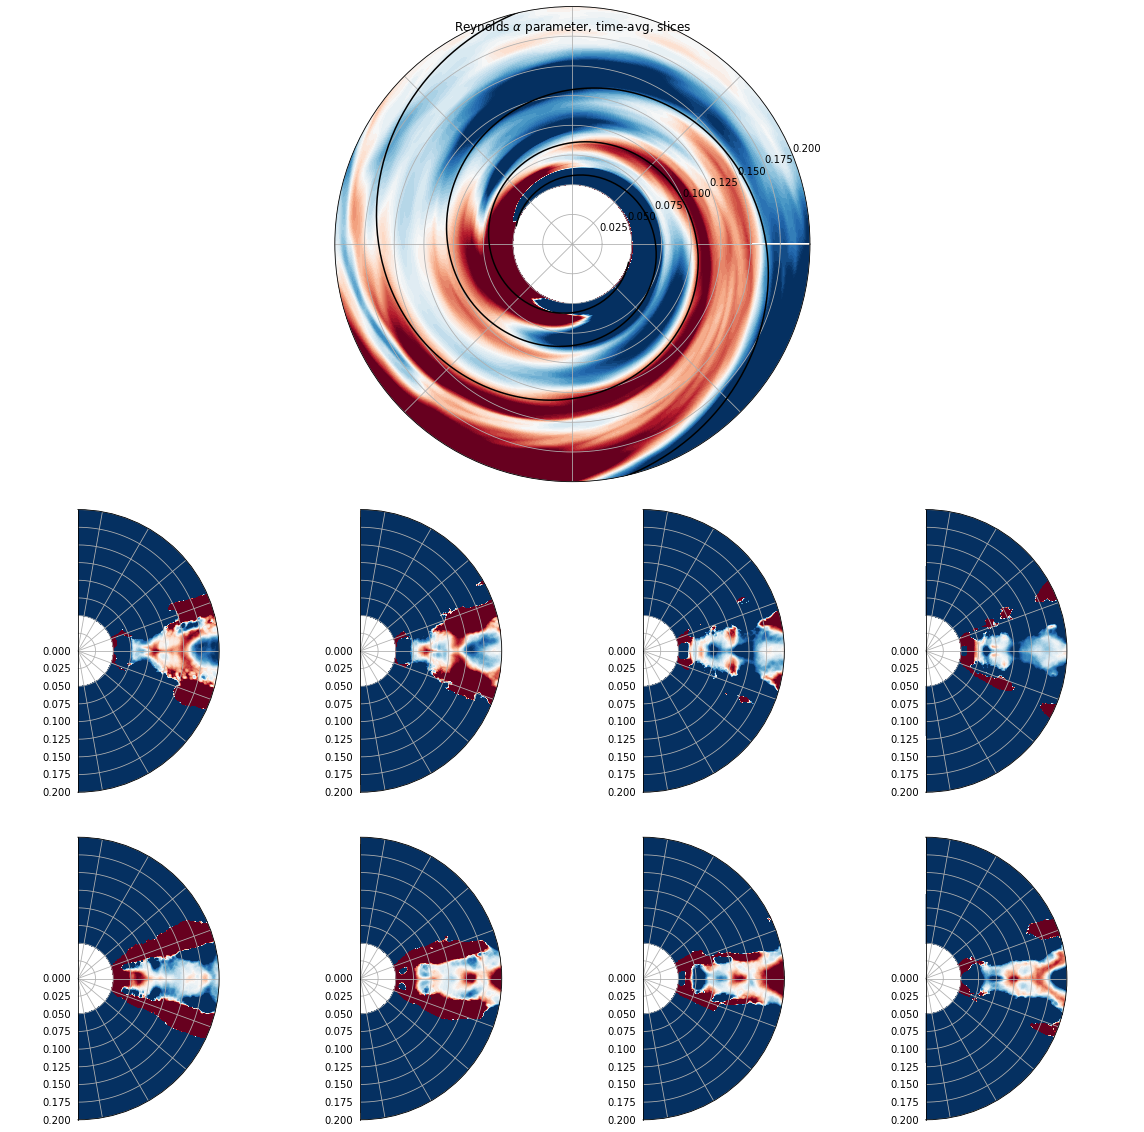

stateB


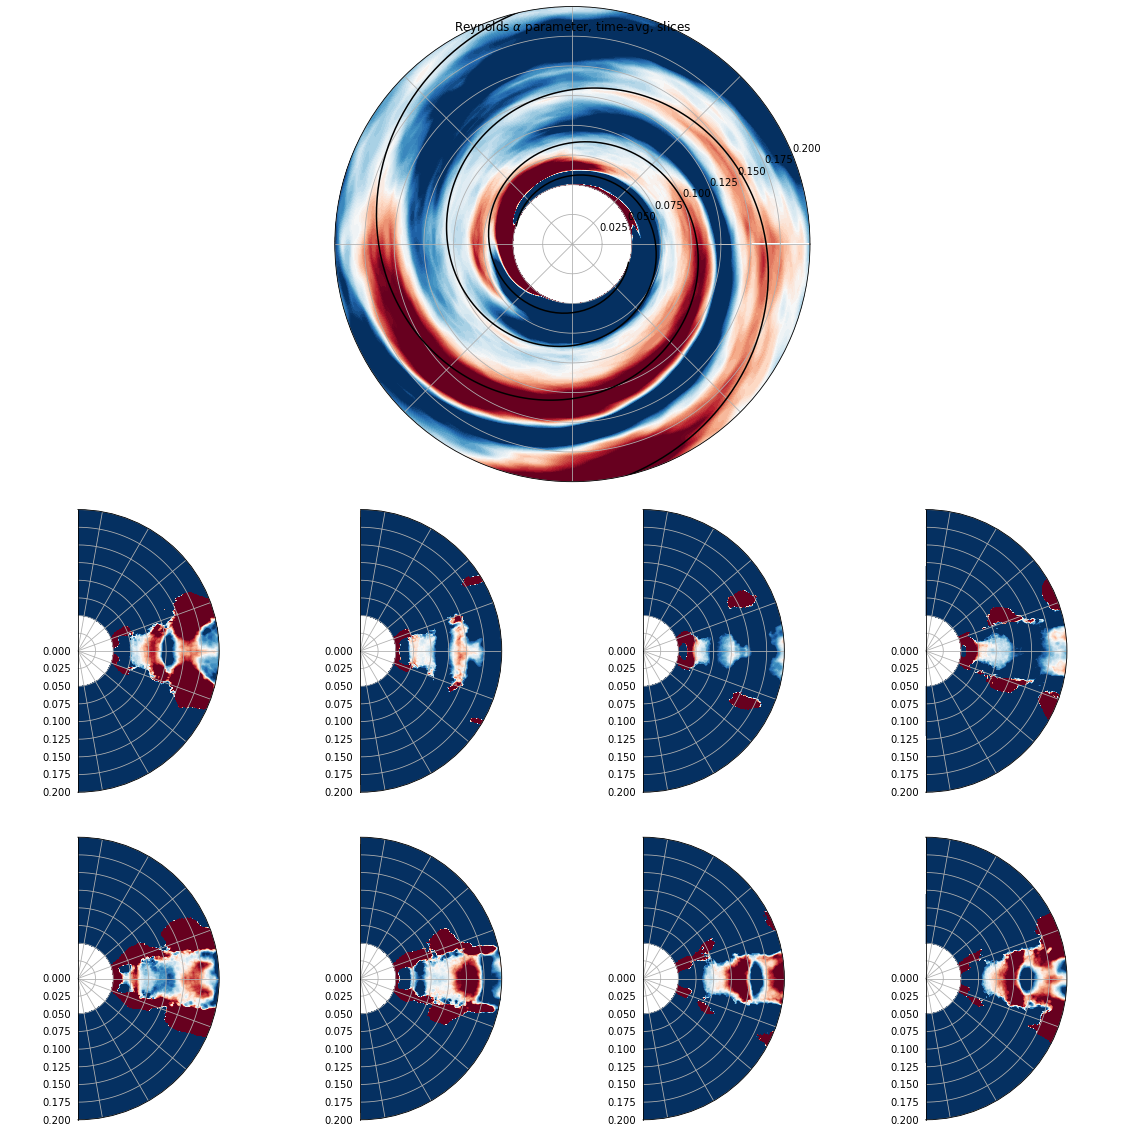

In [11]:
# 2D alpha Reynolds profile

for acc_state in ['None',] + list(accretion_state_times.keys()):
    
    print(state2title(acc_state))

    # load and reuse
    with open(dataset_pathstem + ('%s_AlphaReynoldsSlices.pkl' % state2title(acc_state)), 'rb') as f:
        ops_obj_eq, ops_obj_pol = pkl.load(f)

    # plot
    if save:
        fig = plt.figure(figsize=(8.,8.))
    else:
        fig = plt.figure(figsize=(16.,16.))
    gs = gridspec.GridSpec(3,4, wspace=0., height_ratios=[1.5,1,1])
    kwargs = {'vmin':-0.01, 'vmax':0.01, 'log_scale':False, 'levels':50, 'kwargs':{'cmap':'RdBu'}}
    ax, plot = ops_obj_eq.plot(fig, subplot_spec=gs[0,:], **kwargs)
    ax.set_ylim(0., 0.2)
    data = draw_spiral(np.pi, 0.105, m=2)
    for current_m in range(len(data)-1):
        plt.plot(data[1+current_m], data[0], 'k-')
    
    for npol in range(len(ops_obj_pol)):
        ax, plot = ops_obj_pol[npol].plot(fig, subplot_spec=gs[1+int(npol/4.),npol % 4], **kwargs)
        ax.set_xlim(-0.5*np.pi, 0.5*np.pi)
        ax.set_ylim(0., 0.2)
        
    #plt.subplot(gs[0,3])
    #cbar = fig.colorbar(plot, cax=plt.gca(), ticks=[-0.04, -0.02, 0, 0.02, 0.04])
    plt.suptitle('Reynolds $\\alpha$ parameter, time-avg, slices')
    
    plt.tight_layout()
    if save:
        plt.savefig((output_path + '%s/Mach%i_spirals_%s.png') % (state2title(acc_state), int(mach_no), state2title(acc_state)), fomat='png', dpi=dpi)
    else:
        plt.show()
    plt.close()
    
    del ops_obj_eq, ops_obj_pol

 - The inclination of spirals clearly doesn't stay constant and 'washes away' when averaged over the steady state. We need to find a way to measure it for each snapshot separately and then connect between the snapshots.
 - The same might be true of fitting the spiral structure. Changing inclination widens the spiral structure possibly causing it to mismatch with the expected dispersion relation.
 
Challenges:
 - If plotting for a snapshot, we can't use Reynold's stress -- it's too noisy -- and density contrasts are tiny. It will be extremely difficult to detect the spiral structure...

In [76]:
list(range(32,512,90))

[32, 122, 212, 302, 392, 482]

/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

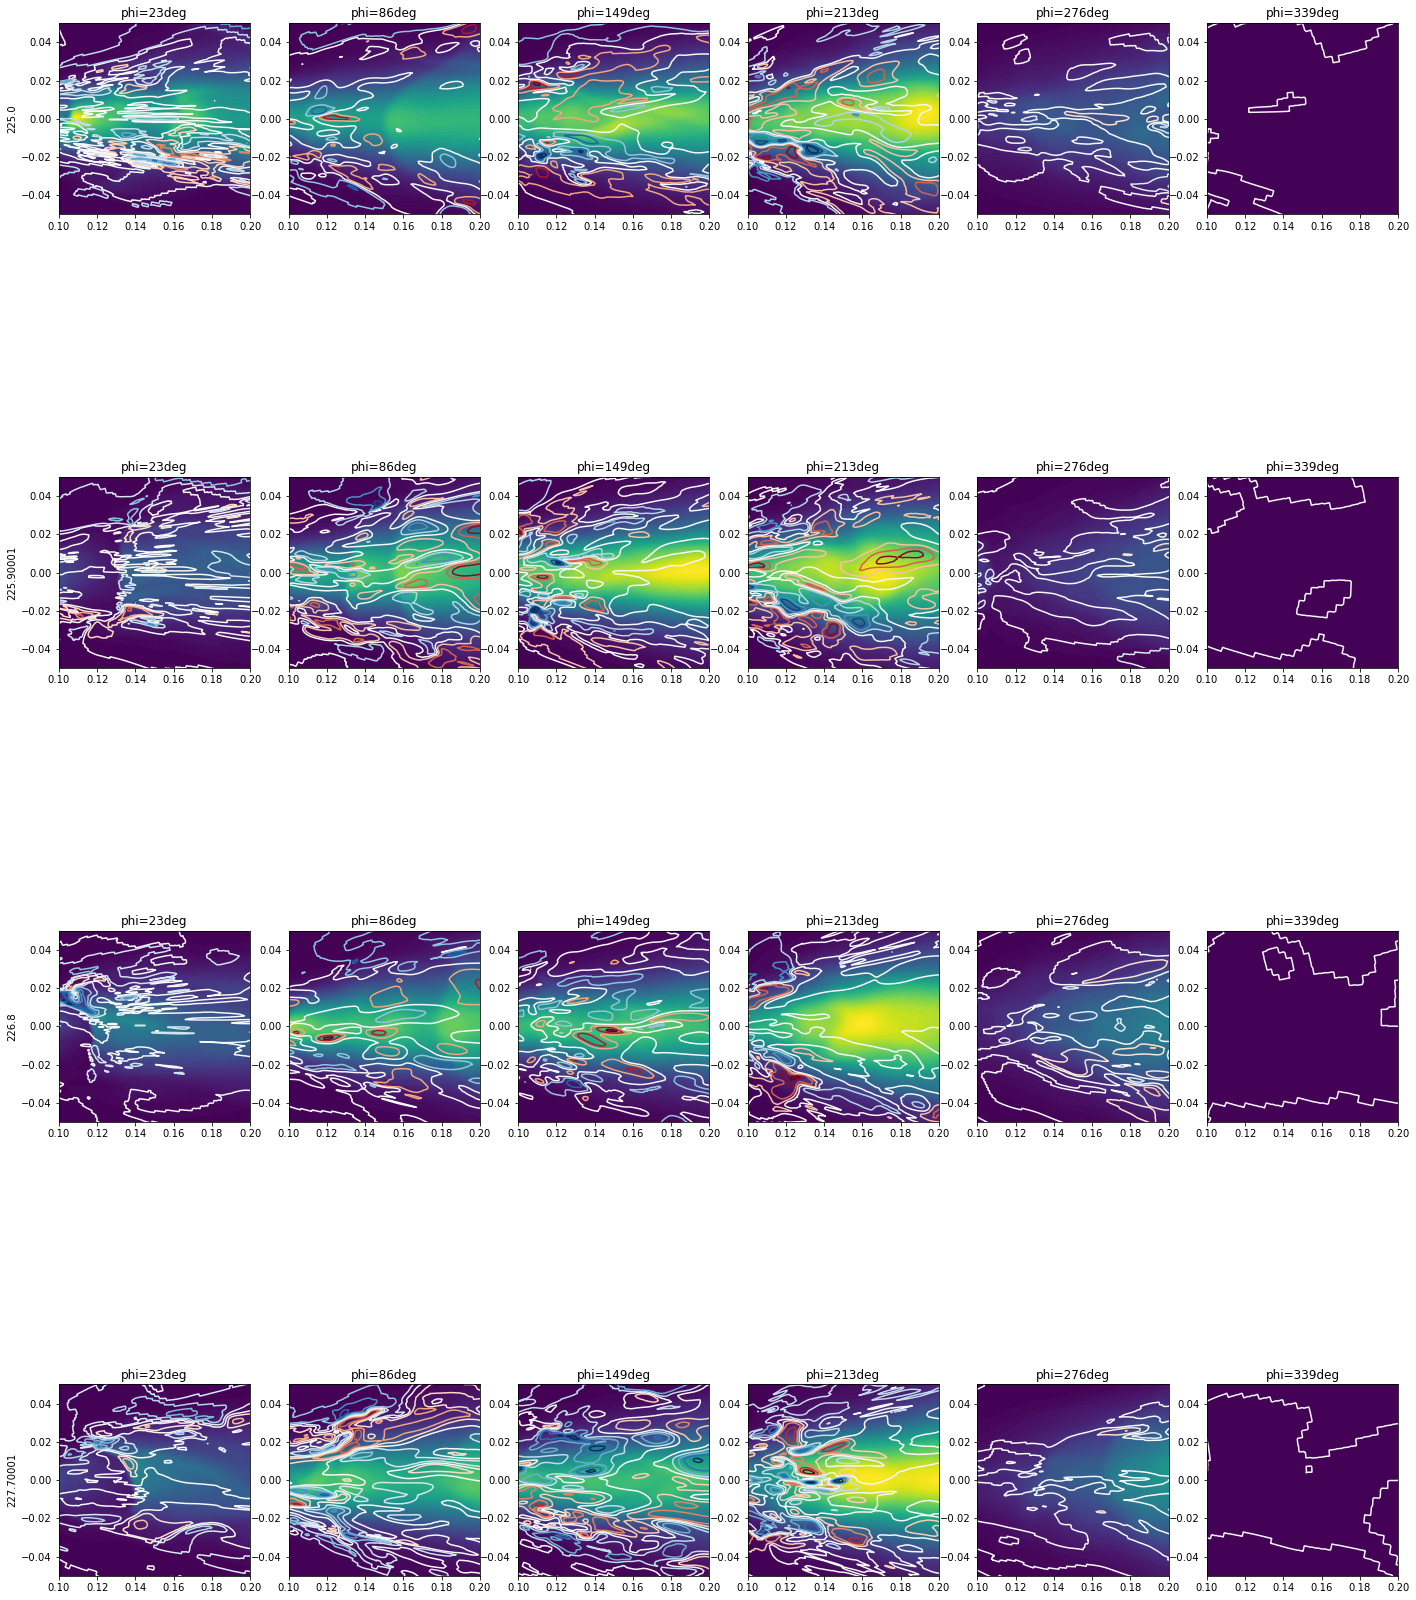

In [77]:
from athena_read import athdf

plt.clf()
fig = plt.figure(figsize=(24,32))

filenos = [750, 753, 756, 759]
indices = list(range(32,512,90))
gs = gridspec.GridSpec(4,6)

for fileno_idx in range(len(filenos)):
    fileno = filenos[fileno_idx]
    data = athdf('/media/ppjanka/DATA_BACKUP/globAcc/M10_v4_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.%05i.athdf' % fileno)

    theta, r = np.meshgrid(data['x2v'], data['x1v'], indexing='ij')
    x = r*np.sin(theta)
    y = r*np.cos(theta)
    
    plt.subplot(gs[fileno_idx, 0])
    plt.ylabel(data['Time'])
    for i in range(len(indices)):
        idx = indices[i]
        plt.subplot(gs[fileno_idx,i])
        plt.tricontourf(x.flatten(), y.flatten(), data['rho'][:,:,idx].transpose().flatten(), levels=100)#, vmin=0.1, vmax=1.6, cmap='Spectral_r')
        #plt.colorbar()
        plt.tricontour(x.flatten(), y.flatten(), data['Bcc3'][:,:,idx].transpose().flatten(), levels=9, vmin=-0.1, vmax=0.1, cmap='RdBu')

        plt.title('phi=%.0fdeg' % (data['x3v'][idx]*180./np.pi))
        plt.xlim(0.1, 0.2)
        plt.ylim(-0.05, 0.05)

        plt.gca().set_aspect('equal')
    del data

plt.show()
plt.close()

In [12]:
with open(dataset_pathstem + ('%s_AlphaReynolds.pkl' % state2title(acc_state)), 'rb') as f:
    ops_obj_eq, _ = pkl.load(f)

In [13]:
anchors_phi = []
for idx_r in range(0, len(ops_obj_eq.r), 16):
    anchors_phi.append([ops_obj_eq.r[idx_r], ops_obj_eq.phi[np.argmin(ops_obj_eq.val[idx_r])]])

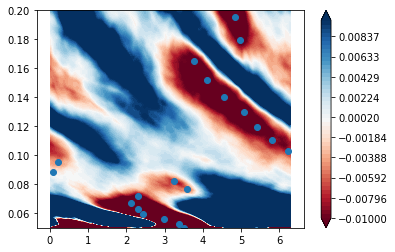

In [14]:
plt.clf()
levels = np.linspace(-0.01, 0.01, 50)
plt.contourf(ops_obj_eq.phi, ops_obj_eq.r, ops_obj_eq.val, levels, vmin=-0.01, vmax=0.01, cmap='RdBu', extend='both')
plt.colorbar()
plt.ylim(0.05, 0.2)

plt.scatter(np.array(anchors_phi)[:,1],np.array(anchors_phi)[:,0])

plt.show()
plt.close()

In [15]:
print(np.array(anchors_phi).shape)

(32, 2)


In [16]:
print(anchors_phi)

[[0.05008475345494758, 3.5158840636722744], [0.052927110125704724, 3.3808937505818903], [0.05605370287982632, 2.9759228113107383], [0.059492955338924805, 2.423689712304622], [0.06327613348524769, 2.3132430925033987], [0.06743762989777992, 2.129165392834693], [0.07201527641202068, 2.3009712458588183], [0.07705068804577972, 3.577243296895176], [0.08258964131761916, 3.233631590846926], [0.08868249039718039, 0.09203884983435273], [0.09538462487057026, 0.202485469635576], [0.10275697328234293, 6.2156903254799545], [0.11086655703167553, 5.8107193862088025], [0.11978709965820022, 5.40574844693765], [0.1295996970564244, 5.074408587533981], [0.14039355471160433, 4.546719181817025], [0.15226679865920476, 4.117204549256712], [0.16532736754033092, 3.773592843208462], [0.17969399386266968, 4.976233814377338], [0.19549728338756533, 4.841243501286954], [0.21288090245579483, 4.558991028461605], [0.23200288404591962, 4.006757929455489], [0.25303706443850893, 0.8528933417983353], [0.27617466354678033, 0

steady


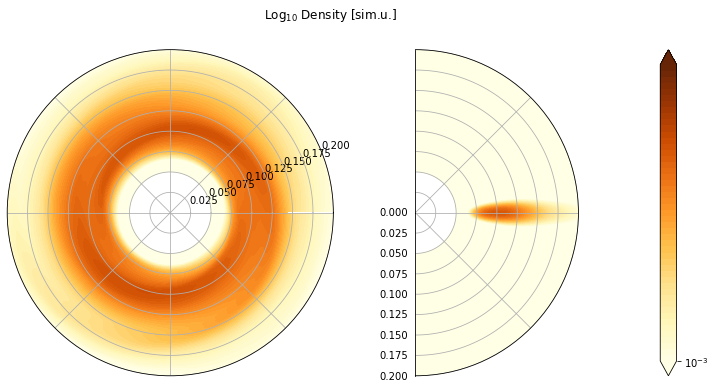

stateA


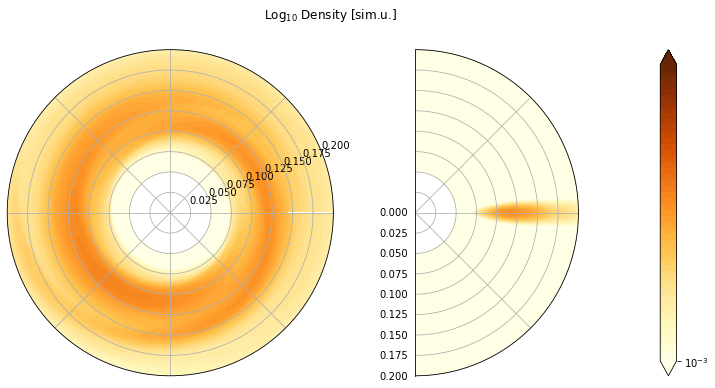

stateB


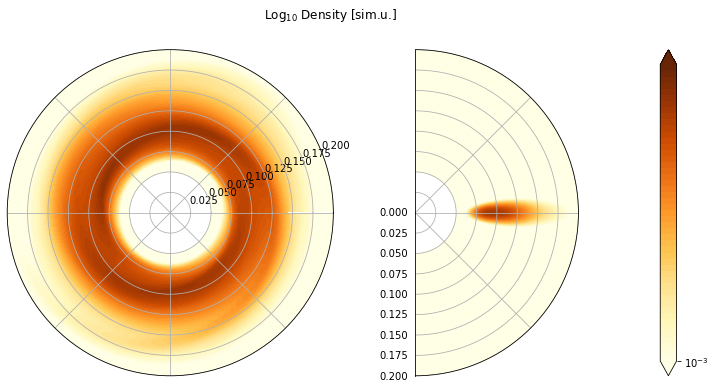

In [17]:
# 2D rho profile

for acc_state in ['None',] + list(accretion_state_times.keys()):
    
    print(state2title(acc_state))

    # load and reuse
    with open(dataset_pathstem + ('%s_rho.pkl' % state2title(acc_state)), 'rb') as f:
        ops_obj_eq, ops_obj_pol = pkl.load(f)

    # plot
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1,3, wspace=0., width_ratios=(1,1,0.05))
    kwargs = {'log_scale':True, 'vmin':1.0, 'vmax':4.0, 'levels':50, 'kwargs':{'cmap':'YlOrBr'}}
    ax, plot = ops_obj_eq.plot(fig, subplot_spec=gs[0,0], **kwargs)
    ax.set_ylim(0., 0.2)
    ax, plot = ops_obj_pol.plot(fig, subplot_spec=gs[0,1], **kwargs)
    ax.set_xlim(-0.5*np.pi, 0.5*np.pi)
    ax.set_ylim(0., 0.2)
    plt.subplot(gs[0,2])
    cbar = fig.colorbar(plot, cax=plt.gca(),
                ticks=[-3,-2,-1,0,1])
    cbar.ax.set_yticklabels(['$10^{-3}$', '$10^{-2}$', '$0.1$', '1', '10'])
    plt.suptitle('Log$_{10}$ Density [sim.u.]')
    
    if save:
        plt.savefig('Mach%i_avg_rho_%s.png' % (int(mach_no), state2title(acc_state)), format='png', dpi=dpi)
    else:
        plt.show()
    plt.close()
    
    del ops_obj_eq, ops_obj_pol

In [9]:
# fit the spiral arms in density

from scipy.signal import argrelextrema, savgol_filter

# load and reuse
with open(dataset_pathstem + 'steady_rho.pkl', 'rb') as f:
    ops_obj_eq, ops_obj_pol = pkl.load(f)
    
r, phi, val = ops_obj_eq.r, ops_obj_eq.phi, ops_obj_eq.val
print(argrelextrema(savgol_filter(val[100,:], 29,3), np.greater))

(array([ 60, 122, 203, 324, 497]),)


In [10]:
print(len(phi))

512


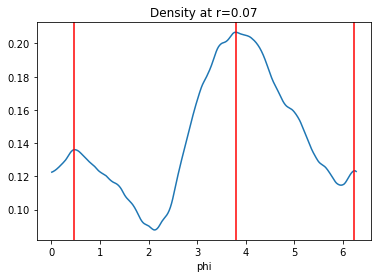

In [20]:
plt.clf()

plt.plot(savgol_filter(phi, 127,3), savgol_filter(val[20,:], 29,3))
plt.title('Density at r=%.2f' % r[100])
plt.xlabel('phi')

for idx in argrelextrema(savgol_filter(val[20,:], 29,3), np.greater)[0]:
    plt.axvline(phi[idx], color='r')

plt.show()
plt.close()

/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/Paper1/figures/diagnostics_ops.py:698: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(subplot_spec, projection='polar')
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/Paper1/figures/diagnostics_ops.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(subplot_spec, projection='polar')


<Figure size 432x288 with 0 Axes>

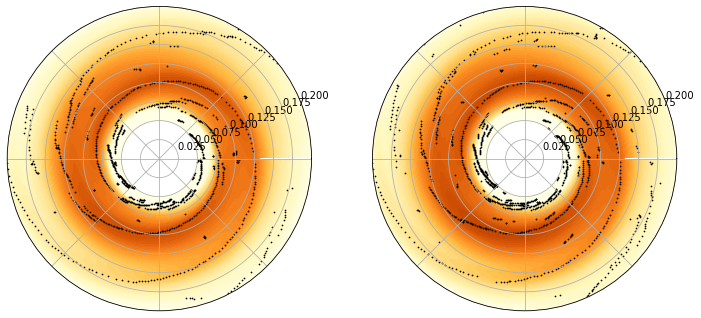

In [21]:
plt.clf()
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(121, projection='polar')

with open(dataset_pathstem + 'steady_rho.pkl', 'rb') as f:
    ops_obj_eq, ops_obj_pol = pkl.load(f)
kwargs = {'log_scale':True, 'vmin':1.0, 'vmax':4.0, 'levels':50, 'kwargs':{'cmap':'YlOrBr'}}
ax, plot = ops_obj_eq.plot(fig, subplot_spec=121, **kwargs)
plt.ylim(0., 0.2)

detections = []

for r_idx in np.arange(len(r)):
    
    if r[r_idx] < 0.05: continue # ignore the noise at the grid edge

    #plt.plot(phi, savgol_filter(val[r_idx,:], 5,3))

    for x in argrelextrema(savgol_filter(val[r_idx,:], 29,3), np.greater)[0]:
        detections.append([phi[x], r[r_idx]])
        plt.scatter(phi[x], r[r_idx], s=0.5, color='k')
        
# -------------------------------------------------------

# density slice
ax = fig.add_subplot(122, projection='polar')

with open(dataset_pathstem + 'steady_rhoSlices.pkl', 'rb') as f:
    ops_obj_eq, ops_obj_pol = pkl.load(f)
r, phi, val = ops_obj_eq.r, ops_obj_eq.phi, ops_obj_eq.val

kwargs = {'log_scale':True, 'vmin':1.0, 'vmax':4.0, 'levels':50, 'kwargs':{'cmap':'YlOrBr'}}
ax, plot = ops_obj_eq.plot(fig, subplot_spec=122, **kwargs)
plt.ylim(0., 0.2)

detections = []

for r_idx in np.arange(len(r)):

    #plt.plot(phi, savgol_filter(val[r_idx,:], 5,3))

    for x in argrelextrema(savgol_filter(val[r_idx,:], 29,3), np.greater)[0]:
        detections.append([phi[x], r[r_idx]])
        plt.scatter(phi[x], r[r_idx], s=0.5, color='k')

plt.show()

plt.close()

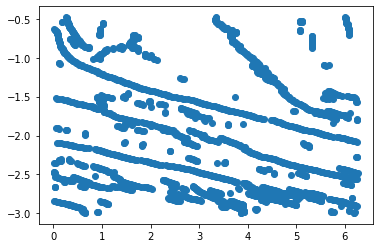

In [22]:
plt.clf()

plt.scatter(np.array(detections).transpose()[0], np.log(np.array(detections).transpose()[1]))

plt.show()
plt.close()

In [ ]:
def find_zero (arr):
    mask = np.array(list(map(lambda idx : (arr[idx]*arr[idx+1] <= 0.), range(len(arr)-1))))
    return np.where(mask)[0]

# vr slice
plt.clf()
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111, projection='polar')

with open(dataset_pathstem + 'steady_vrSlices.pkl', 'rb') as f:
    ops_obj_eq, ops_obj_pol = pkl.load(f)
r, phi, val = ops_obj_eq.r, ops_obj_eq.phi, ops_obj_eq.val

kwargs = {'log_scale':False, 'vmin':-0.4, 'vmax':0.4, 'levels':50, 'kwargs':{'cmap':'RdBu'}}
ax, plot = ops_obj_eq.plot(fig, subplot_spec=111, **kwargs)
plt.ylim(0., 0.2)

detections_vr = []

for r_idx in np.arange(len(r)):

    #plt.plot(phi, val[r_idx,:])
    #import sys; sys.exit()
    
    if True:# r[r_idx] < 0.15:
        smoothed = savgol_filter(np.abs(val[r_idx,:]), 15,3)
    else:
        smoothed = np.abs(val[r_idx,:])

    for x in argrelextrema(smoothed, np.less)[0]:
        detections_vr.append([phi[x], r[r_idx]])
        plt.scatter(phi[x], r[r_idx], s=0.5, color='k')

plt.show()

plt.close()

/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/Paper1/figures/diagnostics_ops.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(subplot_spec, projection='polar')


<Figure size 432x288 with 0 Axes>

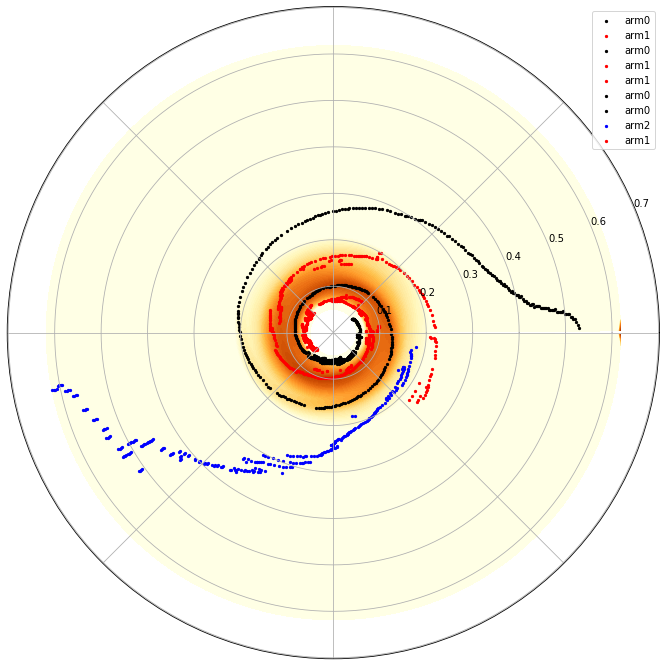

In [23]:
from sklearn.cluster import DBSCAN

fittype = 'slice'

arm_labels = {}
if fittype == 'profile':
    clf = DBSCAN(eps=0.15)
    arm_labels[0] = [0,2,11]
    arm_labels[1] = [1,4,5,7,13,14]
    arm_colors = ['k', 'r']
elif fittype == 'slice':
    clf = DBSCAN(eps=0.15)
    arm_labels[0] = [0,2,11,13]
    arm_labels[1] = [1,5,6,15]
    arm_labels[2] = [14]
    arm_colors = ['k', 'r','b']

arms_points = []
for i in range(len(arm_labels.keys())):
    arms_points.append([[],[]])

plt.clf()
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='polar')

if fittype == 'profile':
    with open(dataset_pathstem + 'steady_rho.pkl', 'rb') as f:
        ops_obj_eq, ops_obj_pol = pkl.load(f)
elif fittype == 'slice':
    with open(dataset_pathstem + 'steady_rhoSlices.pkl', 'rb') as f:
        ops_obj_eq, ops_obj_pol = pkl.load(f)
kwargs = {'log_scale':True, 'vmin':1.0, 'vmax':4.0, 'levels':50, 'kwargs':{'cmap':'YlOrBr'}}
ax, plot = ops_obj_eq.plot(fig, subplot_spec=111, **kwargs)

detections_cartesian = np.array(detections).transpose()
#detections_cartesian = np.array([detections_cartesian[1]*np.cos(detections_cartesian[0]), detections_cartesian[1]*np.sin(detections_cartesian[0])]).transpose()
# logscale in r works better for clustering
detections_cartesian = np.array([detections_cartesian[0], np.log(detections_cartesian[1])]).transpose()

clustering = clf.fit(np.array(detections_cartesian))

for label in np.unique(clustering.labels_):
    blah = np.array(detections)[np.array(clustering.labels_) == label].transpose()
    plotted = False
    for arm_label in arm_labels.keys():
        if label in arm_labels[arm_label]:
            
            if arm_label == 0:
                # manual cleanup
                mask = np.where(((blah[0] < 0.75*np.pi) | (blah[0] > np.pi) | (blah[1] > 0.19) | (blah[1] < 0.1)) \
                               & ((blah[0] < np.pi) | (blah[0] > 1.25*np.pi) | (blah[1] > 0.18) | (blah[1] < 0.1)) \
                               & ((blah[0] < 0.3*np.pi) | (blah[0] > 0.6*np.pi) | (blah[1] > 0.23) | (blah[1] < 0.2)) \
                               & ((blah[0] < 0.1*np.pi) | (blah[0] > 0.25*np.pi) | (blah[1] < 0.39)) \
                               & ((blah[0] < 0.6*np.pi) | (blah[0] > 0.87*np.pi) | (blah[1] > 0.21) | (blah[1] < 0.15)) \
                               & ((blah[0] < 0.3*np.pi) | (blah[0] > 0.65*np.pi) | (blah[1] > 0.24) | (blah[1] < 0.15)) \
                               & ((blah[0] < 0.75*np.pi) | (blah[0] > np.pi) | (blah[1] > 0.15) | (blah[1] < 0.095)) \
                               & ((blah[0] < 0.25*np.pi) | (blah[1] < 0.33)) \
                               & (blah[1] < 0.55))[0]
                blah = np.array(detections)[np.array(clustering.labels_) == label]
                blah = blah[mask].transpose()
            elif arm_label == 1 and fittype == 'slice':
                # manual cleanup
                mask = np.where(((blah[0] < 0.26*np.pi) | (blah[0] > np.pi) | (blah[1] < 0.2)) )[0]
                blah = np.array(detections)[np.array(clustering.labels_) == label]
                blah = blah[mask].transpose()
            
            plt.scatter(blah[0], blah[1], s=5., label=('arm%i' % arm_label), color=arm_colors[arm_label])
            for idx in [0,1]:
                arms_points[arm_label][idx].extend(blah[idx])
            plotted = True
    #if not plotted:
        #plt.scatter(blah[0], blah[1], s=5., label=label)
    
plt.ylim(0., None)
plt.legend()
    
plt.show()
plt.close()

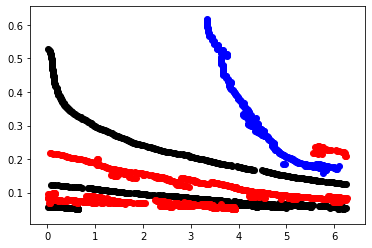

In [24]:
plt.clf()

for arm_label in arm_labels.keys():
    plt.scatter(arms_points[arm_label][0], arms_points[arm_label][1], color=arm_colors[arm_label])

plt.show()
plt.close()

In [25]:
# returns a table of phi's for a given table of r's, for a spiral density wave following linear equations with the parameters given
def single_spiral (rtable, phi0, m=2, omega_pattern=1.0, steps_r=20,\
                   csound='locIsoth', omega='kepl',\
                   ops_obj_eq_csound=None, ops_obj_eq_vel3=None, ops_obj_eq_rho=None, ops_obj_eq_bfield=None):
    
    # configure
    if csound == 'locIsoth':
        mach_fun = mach_locIsoth
    elif csound == 'real':
        mach_fun = (lambda r, phi : mach_true(r, phi, ops_obj_eq_vel3=ops_obj_eq_vel3, ops_obj_eq_csound=ops_obj_eq_csound))
    elif csound == 'sms':
        mach_fun = (lambda r, phi : mach_sms(r, phi, ops_obj_eq_rho=ops_obj_eq_rho, ops_obj_eq_bfield=ops_obj_eq_bfield, ops_obj_eq_csound=ops_obj_eq_csound, ops_obj_eq_vel3=ops_obj_eq_vel3))
    elif csound == 'fms':
        mach_fun = (lambda r, phi : mach_fms(r, phi, ops_obj_eq_rho=ops_obj_eq_rho, ops_obj_eq_bfield=ops_obj_eq_bfield, ops_obj_eq_csound=ops_obj_eq_csound, ops_obj_eq_vel3=ops_obj_eq_vel3))
        
    if omega == 'kepl':
        omega_fun = omega_keplerian
    elif omega == 'real':
        omega_fun = (lambda r, phi : omega_true(r, phi, ops_obj_eq_vel3=ops_obj_eq_vel3))
    
    # calculate the model curve
    r = 1.*rtable[0]; phi=1.*phi0
    phis = []; phis.append(phi)
    
    for ridx in range(len(rtable)-1):
        dr = (rtable[ridx+1] - r)/steps_r
        while r < rtable[ridx+1]:
            phi -= dr / (r * tan_pitch(mach_fun(r, phi), omega_pattern, omega_fun(r, phi), m))
            r += dr
        phis.append(phi)
    
    return np.array(phis)

steps_r = 1000
def draw_single_spiral (phi0, r0=x1min, dr=(x1max-x1min)/steps_r, m=2, omega_pattern=1.0, mach_no=mach_no,\
                        rmin=x1min, rmax=x1max,\
                        csound='locIsoth', omega='kepl',\
                        ops_obj_eq_csound=None, ops_obj_eq_vel3=None,\
                        ops_obj_eq_rho=None, ops_obj_eq_bfield=None):
    
    if rmin == None: rmin = x1min
    if rmax == None: rmax = x1max
        
    # configure
    if csound == 'locIsoth':
        mach_fun = mach_locIsoth
    elif csound == 'real':
        mach_fun = (lambda r, phi : mach_true(r, phi, ops_obj_eq_vel3=ops_obj_eq_vel3, ops_obj_eq_csound=ops_obj_eq_csound))
    elif csound == 'sms':
        mach_fun = (lambda r, phi : mach_sms(r, phi, ops_obj_eq_rho=ops_obj_eq_rho, ops_obj_eq_bfield=ops_obj_eq_bfield, ops_obj_eq_csound=ops_obj_eq_csound, ops_obj_eq_vel3=ops_obj_eq_vel3))
    elif csound == 'fms':
        mach_fun = (lambda r, phi : mach_fms(r, phi, ops_obj_eq_rho=ops_obj_eq_rho, ops_obj_eq_bfield=ops_obj_eq_bfield, ops_obj_eq_csound=ops_obj_eq_csound, ops_obj_eq_vel3=ops_obj_eq_vel3))
        
    if omega == 'kepl':
        omega_fun = omega_keplerian
    elif omega == 'real':
        omega_fun = (lambda r, phi : omega_true(r, phi, ops_obj_eq_vel3=ops_obj_eq_vel3))
    
    # calculate and plot the curve
    r = r0; phi=phi0
    phis = [phi,]; rs = [r,]
    
    while r > rmin:
        phi += dr / (r * tan_pitch(mach_fun(r, phi), omega_pattern, omega_fun(r, phi), m))
        r -= dr
        phis.append(phi), rs.append(r)
    phis = phis[::-1]
    rs = rs[::-1]

    r = r0; phi=phi0
    while r < rmax:
        phi -= dr / (r * tan_pitch(mach_fun(r, phi), omega_pattern, omega_fun(r, phi), m))
        r += dr
        phis.append(phi), rs.append(r)
    result = [np.array(rs), np.array(phis)]
    
    return np.array(result)

from scipy.spatial.distance import cdist
def l2ish (rs1, phis1, rs2, phis2):

    C1 = np.array([rs1*np.cos(phis1), rs1*np.sin(phis1)]).transpose()
    C2 = np.array([rs2*np.cos(phis2), rs2*np.sin(phis2)]).transpose()

    distance_matrix = cdist(C2, C1, 'sqeuclidean')
    distances = np.min(distance_matrix, axis=1)
    
    #distances = 0.5 * (distances[1:] + distances[:-1])
    #logrs1 = np.log(rs1)
    #weights = logrs1[1:] - logrs1[:-1] #dr1/r1
    
    return np.sum(distances) # * weights) # trapezoid integral over log-radius

def check_par_fit (arm_points, phi0, m=2, omega_pattern=1.0, steps_r=1, rmin=0.0, rmax=1.0e6,\
                   csound='locIsoth', omega='kepl',\
                   ops_obj_eq_csound=None, ops_obj_eq_vel3=None, ops_obj_eq_rho=None, ops_obj_eq_bfield=None):
    
    mask = np.where((np.array(arm_points[1]) > rmin) & (np.array(arm_points[1]) < rmax))[0]
    
    r_model = arm_points[1][mask]
    r_model = np.linspace(np.min(r_model), np.max(r_model), steps_r * len(r_model)) # prevents overweighing small radii
    phi_model = single_spiral(rtable=r_model, phi0=phi0,\
                              csound=csound, omega=omega,\
                              ops_obj_eq_csound=ops_obj_eq_csound, ops_obj_eq_vel3=ops_obj_eq_vel3,\
                              ops_obj_eq_rho=ops_obj_eq_rho, ops_obj_eq_bfield=ops_obj_eq_bfield)
    
    return l2ish(arm_points[1][mask], arm_points[0][mask], r_model, phi_model)

In [65]:
# read the true equatorial slices of vel3 and csound
with open(dataset_pathstem + 'steady_rhoSlices.pkl', 'rb') as f:
    ops_obj_eq_rho, _ = pkl.load(f)
with open(dataset_pathstem + 'steady_vel3Slices.pkl', 'rb') as f:
    ops_obj_eq_vel3, _ = pkl.load(f)
with open(dataset_pathstem + 'steady_csoundSlices.pkl', 'rb') as f:
    ops_obj_eq_csound, _ = pkl.load(f)
with open(dataset_pathstem + 'steady_bfieldSlices.pkl', 'rb') as f:
    ops_obj_eq_bfield, _ = pkl.load(f)
    
force_locIsoth = True

def arm_config (armidx):
    
    if armidx == 0:
        if True or force_locIsoth: # original config
            rmin = 0.
            rmax = 0.3
            csound = 'locIsoth'
            omega = 'kepl'
            # use the idealized (~ disk-avg) conditions (better fit)
            ops_obj_eq_csound_here = None
            ops_obj_eq_vel3_here = None
            ops_obj_eq_rho_here = None
            ops_obj_eq_bfield_here = None
        else: # magnetosonic config
            rmin = 0.
            rmax = 0.3
            csound = 'fms'
            omega = 'kepl'
            # use the idealized (~ disk-avg) conditions (better fit)
            ops_obj_eq_csound_here = ops_obj_eq_csound
            ops_obj_eq_vel3_here = ops_obj_eq_vel3
            ops_obj_eq_rho_here = ops_obj_eq_rho
            ops_obj_eq_bfield_here = ops_obj_eq_bfield
    elif armidx == 1:
        if True or force_locIsoth: # original config
            rmin = 0.
            rmax = 1.0e6
            csound = 'locIsoth'
            omega = 'kepl'
            # use the idealized (~ disk-avg) conditions (better fit)
            ops_obj_eq_csound_here = None
            ops_obj_eq_vel3_here = None
            ops_obj_eq_rho_here = None
            ops_obj_eq_bfield_here = None
        else: # magnetosonic config
            rmin = 0.
            rmax = 1.0e6
            csound = 'fms'
            omega = 'kepl'
            # use the idealized (~ disk-avg) conditions (better fit)
            ops_obj_eq_csound_here = ops_obj_eq_csound
            ops_obj_eq_vel3_here = ops_obj_eq_vel3
            ops_obj_eq_rho_here = ops_obj_eq_rho
            ops_obj_eq_bfield_here = ops_obj_eq_bfield
    elif armidx == 2:
        if True or force_locIsoth: # original config
            rmin = 0.
            rmax = 0.3
            csound = 'locIsoth'
            omega = 'kepl'
            # use the idealized (~ disk-avg) conditions (better fit)
            ops_obj_eq_csound_here = None
            ops_obj_eq_vel3_here = None
            ops_obj_eq_rho_here = None
            ops_obj_eq_bfield_here = None
        else: # magnetosonic config
            rmin = 0.
            rmax = 0.3
            csound = 'fms'
            omega = 'kepl'
            # use the idealized (~ disk-avg) conditions (better fit)
            ops_obj_eq_csound_here = ops_obj_eq_csound
            ops_obj_eq_vel3_here = ops_obj_eq_vel3
            ops_obj_eq_rho_here = ops_obj_eq_rho
            ops_obj_eq_bfield_here = ops_obj_eq_bfield
        
    return rmin, rmax, csound, omega, ops_obj_eq_csound_here, ops_obj_eq_vel3_here, ops_obj_eq_rho_here, ops_obj_eq_bfield_here

Processing arm no 0


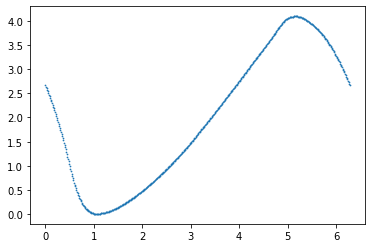

 - optimal parameters:  [1.0574441 2.       ]
Processing arm no 1


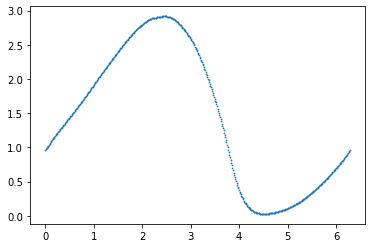

 - optimal parameters:  [4.51258123 2.        ]
Processing arm no 2


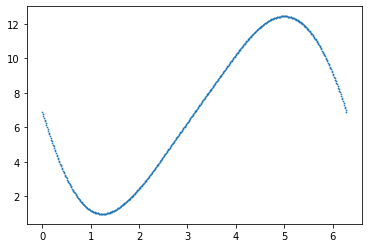

 - optimal parameters:  [1.24188203 2.        ]


In [66]:
nproc = 4

# define parameter space to survey
phi0s = np.linspace(0., 2.*np.pi, 512)
ms = np.array([2,]) # seem to have negligible effect
phi0s_grid, ms_grid = np.meshgrid(phi0s, ms)
phi0s_grid = phi0s_grid.flatten()
ms_grid = ms_grid.flatten()
pars = np.array([phi0s_grid, ms_grid]).transpose()

phi0s_opt = {}
for armidx in range(len(arms_points)):
    
    print('Processing arm no %i' % armidx, flush=True)

    rmin, rmax, csound, omega, ops_obj_eq_csound_here, ops_obj_eq_vel3_here, ops_obj_eq_rho_here, ops_obj_eq_bfield_here = arm_config(armidx)
    
    def check_par_fit_here (parss):
        phi0, m = parss
        return check_par_fit(arm_points=np.array(arms_points[armidx]), phi0=phi0, m=m, rmin=rmin, rmax=rmax,\
                              csound=csound, omega=omega,\
                              ops_obj_eq_csound=ops_obj_eq_csound, ops_obj_eq_vel3=ops_obj_eq_vel3,\
                              ops_obj_eq_rho=ops_obj_eq_rho, ops_obj_eq_bfield=ops_obj_eq_bfield)

    if nproc > 1:
        from multiprocessing import Pool
        with Pool(4) as pool:
            l2ishs = np.array(pool.map(check_par_fit_here, pars))
    else:
        from tqdm import tqdm
        l2ishs = []
        for par in tqdm(pars):
            l2ishs.append(check_par_fit_here(par))
        l2ishs = np.array(l2ishs)
    
    plt.clf()
    if len(ms) > 1:
        mask = np.invert(np.isnan(l2ishs))
        plt.tricontourf(phi0s_grid[mask], ms_grid[mask], l2ishs[mask], 100)
    else:
        plt.scatter(phi0s.flatten(), l2ishs.flatten(), s=0.5)
    plt.show()
    plt.close()

    idopt = np.nanargmin(l2ishs)
    phi0, m = pars[idopt]
    phi0s_opt[armidx] = 1.*phi0
    print(" - optimal parameters: ", pars[idopt], flush=True)

/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


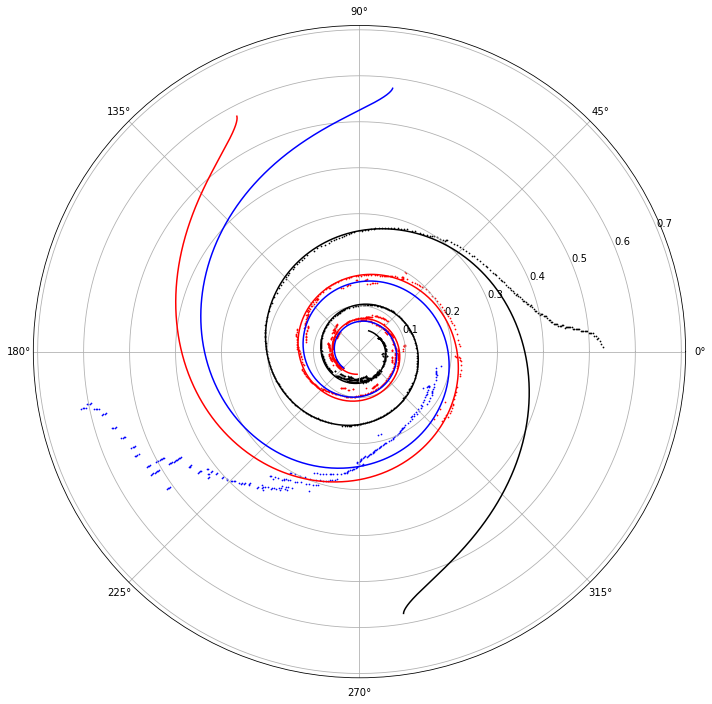

In [67]:
rs = np.linspace(0.05, 0.5,100)

plt.clf()
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111,projection='polar')
for armidx in range(len(arms_points)):
    plt.scatter(arms_points[armidx][0], arms_points[armidx][1], color=arm_colors[armidx],s=0.5)
    rmin=np.min(arms_points[armidx][1])
    if True:# armidx != 2:
        r, phi = draw_single_spiral(phi0=phi0s_opt[armidx], r0=rmin, m=2)
        ax.plot(phi, r, color=arm_colors[armidx])
plt.ylim(0., None)
    
plt.show()
plt.close()

In [68]:
import pickle as pkl

with open(dataset_pathstem + 'spirals.pkl', 'wb') as f:
    pkl.dump((arms_points, phi0s_opt), f)

In [ ]:
with open(dataset_pathstem + 'steady_rho3D.pkl', 'rb') as f:
    data3D = pkl.load(f)

In [ ]:
data3D.val.shape

In [ ]:
test = data3D.val[:,256,:]

In [ ]:
fig = plt.figure()
fig.add_subplot(111, projection='polar')
plt.contourf(data3D.phi, data3D.r, test)
plt.ylim(0., 0.2)
plt.show()
plt.close()

In [ ]:
# for each phi,r (spherical) pencil, return height R,phi,z (cylindrical) of the highest and lowest density isosurface
def isopoints (level, phi_idx, r_idx, data3D):
    pencil = data3D.val[r_idx, :, phi_idx]
    higher = np.where(pencil > level)[0]
    if len(higher) < 2: return [None, None, None, None]
    theta_idx_min, theta_idx_max = min(higher), max(higher)
    theta_min, theta_max = data3D.theta[theta_idx_min], data3D.theta[theta_idx_max]
    phi = data3D.phi[phi_idx]
    r = data3D.r[r_idx]
    return [r, phi, theta_min, theta_max]

def isosurface (level, data3D):
    idxs_phi, idxs_r = np.meshgrid(range(len(data3D.phi)), range(len(data3D.r)), indexing='ij')
    idxs_phi = idxs_phi.flatten()
    idxs_r = idxs_r.flatten()
    points = map(lambda phi_idx, r_idx : isopoints(level, phi_idx, r_idx, data3D), idxs_phi, idxs_r)
    points = np.array(list(points))
    points = points[points[:,0] != None]
    return np.array(points).transpose().astype(np.float)

In [ ]:
print(isopoints(1., 256, 10, data3D))

In [ ]:
blah = isosurface(1., data3D)

In [ ]:
blah[0]

In [ ]:
for acc_state in ['None',] + list(accretion_state_times.keys()):
    
    print(state2title(acc_state))
    
    for logrho_level in np.linspace(-2., np.log10(2.5), 5):

        rho_level = 10.**logrho_level

        print('Density level: %.2f sim.u.' % rho_level)

        # calculate isosurfaces
        blah = isosurface(rho_level, data3D)

        # plot

        gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.1])

        plt.clf()
        fig = plt.figure(figsize=[7.,3.5])

        theta_min = blah[2] # min
        zmin = np.cos(theta_min) * blah[0]
        xmin = np.sin(theta_min) * blah[0] * np.cos(blah[1])
        ymin = np.sin(theta_min) * blah[0] * np.sin(blah[1])

        theta_max = blah[3] # max
        zmax = np.abs(np.cos(theta_max) * blah[0])
        xmax = np.sin(theta_max) * blah[0] * np.cos(blah[1])
        ymax = np.sin(theta_max) * blah[0] * np.sin(blah[1])

        vmax=max([max(zmin), max(zmax)])
        size = max([abs(min(ymin)), abs(max(ymin)), abs(min(ymax)), abs(max(ymax))])

        plt.subplot(gs[0,0])
        plt.title('Bottom isosurface')
        plt.tricontourf(xmin, ymin, zmin, 50, vmin=0., vmax=vmax)
        plt.subplot(gs[0,1])
        plt.title('Top isosurface')
        sm = plt.tricontourf(xmax, ymax, zmax, 50, vmin=0., vmax=vmax)

        for col in [0,1]:
            plt.subplot(gs[0,col])
            plt.xlim(-size, size)
            plt.ylim(-size, size)
            plt.gca().set_aspect(1.)
            plt.xlabel('x [sim.u.]')
            if col == 0:
                plt.ylabel('y [sim.u.]')
            else:
                plt.gca().get_yaxis().set_visible(False)

        plt.subplot(gs[0,2])
        cb = plt.colorbar(sm, cax=plt.gca())
        plt.ylabel('z [sim.u.]')
        plt.suptitle('Isosurfaces for $\\rho=%.2f$' % rho_level)

        if save:
            plt.savefig((output_path + '%s/Mach%i_isosurf_rho%03i_%s.png') % (state2title(acc_state), int(mach_no), int(100.*rho_level), state2title(acc_state)), format='png', dpi=dpi)
        else:
            plt.show()
        plt.close()

In [80]:
with open(dataset_pathstem + 'steady_rho3D.pkl', 'rb') as f:
    data3D = pkl.load(f)
    
with open(dataset_pathstem + 'steady_csound3D.pkl', 'rb') as f:
    data3D_csound = pkl.load(f)
    
with open(dataset_pathstem + 'steady_vel13D.pkl', 'rb') as f:
    data3D_vel1 = pkl.load(f)    
with open(dataset_pathstem + 'steady_vel23D.pkl', 'rb') as f:
    data3D_vel2 = pkl.load(f)    
with open(dataset_pathstem + 'steady_vel33D.pkl', 'rb') as f:
    data3D_vel3 = pkl.load(f)

In [106]:
# for each phi,r (spherical) pencil, return height r,phi,z (spherical r!) of the highest and lowest density isosurface
def isopoints (level, phi_idx, r_idx, data3D):
    pencil = data3D.val[r_idx, :, phi_idx]
    higher = np.where(pencil > level)[0]
    if len(higher) < 2: return [None, None, None, None]
    theta_idx_min, theta_idx_max = min(higher), max(higher)
    theta_min, theta_max = data3D.theta[theta_idx_min], data3D.theta[theta_idx_max]
    phi = data3D.phi[phi_idx]
    r = data3D.r[r_idx]
    return [r, phi, theta_min, theta_max]

def isosurface (level, data3D, cleanup=True):
    idxs_phi, idxs_r = np.meshgrid(range(len(data3D.phi)), range(len(data3D.r)), indexing='ij')
    print(idxs_phi.shape)
    idxs_phi = idxs_phi.flatten()
    idxs_r = idxs_r.flatten()
    points = map(lambda phi_idx, r_idx : isopoints(level, phi_idx, r_idx, data3D), idxs_phi, idxs_r)
    points = np.array(list(points))
    if cleanup:
        points = points[points[:,0] != None]
    return np.array(points).transpose().astype(np.float)

def isopoints_dopp (level, phi_idx, r_idx, data3D):
    pencil = data3D.val[r_idx, :, phi_idx]
    higher = np.where(pencil > level)[0]
    if len(higher) < 2: return [None, None, None, None, 0,0,0]
    theta_idx_min, theta_idx_max = min(higher), max(higher)
    theta_min, theta_max = data3D.theta[theta_idx_min], data3D.theta[theta_idx_max]
    phi = data3D.phi[phi_idx]
    r = data3D.r[r_idx]
    return [r, phi, theta_min, theta_max, 1.*phi_idx, 1.*theta_idx_min, 1.*r_idx]

def isosurface_dopp (level, data3D, cleanup=False):
    idxs_phi, idxs_r = np.meshgrid(range(len(data3D.phi)), range(len(data3D.r)), indexing='ij')
    print(idxs_phi.shape)
    idxs_phi = idxs_phi.flatten()
    idxs_r = idxs_r.flatten()
    points = map(lambda phi_idx, r_idx : isopoints_dopp(level, phi_idx, r_idx, data3D), idxs_phi, idxs_r)
    points = np.array(list(points))
    if cleanup:
        points = points[points[:,0] != None]
    return np.array(points).transpose().astype(np.float)

# calculated approx dS corresponding to each of the isosurface's points as projected onto the isosurface (for Doppler diagrams)
def calc_isosurf_dS (isosurf, data3D):
    r, phi, theta, _, _, _, _ = isosurf
    # reshape to regain neighbourhood information
    shape = (len(data3D.phi), len(data3D.r))
    print(shape)
    r, phi, theta = r.reshape(shape), phi.reshape(shape), theta.reshape(shape)
    # transform to cartesian
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    # calculate distances between neighbouring points
    dl = {}
    for ax in range(2):
        dx = np.roll(x,-1,axis=ax) - x
        dy = np.roll(y,-1,axis=ax) - y
        dz = np.roll(z,-1,axis=ax) - z
        dl[ax] = np.sqrt(dx**2+dy**2+dz**2)
    dl[1][:,-1] = dl[1][:,-2]
    # calculate surfaces on isosurface corresponding to each point
    dS = 0.5*(dl[0] + np.roll(dl[0],-1, axis=0)) * 0.5*(dl[1] + np.roll(dl[1],-1, axis=1))
    
    return dS

from tqdm import tqdm
def doppler_diagram (dS, isosurf, data3D_vel1, data3D_vel2, data3D_vel3, data3D_csound, nbins=64):
    r, theta, phi = np.meshgrid(data3D_vel1.r, data3D_vel1.theta, data3D_vel1.phi, indexing='ij')
    # transform velocities to cartesian coordinates, vx and vy only
    vx = data3D_vel1.val * np.sin(theta)*np.cos(phi)\
        + data3D_vel2.val * np.cos(theta)*np.cos(phi)\
        - data3D_vel3.val * np.sin(phi)\
        + r * np.sin(phi) # correct for frame rotation
    vy = data3D_vel1.val * np.sin(theta)*np.sin(phi)\
        + data3D_vel2.val * np.cos(theta)*np.sin(phi)\
        + data3D_vel3.val * np.cos(phi)\
        - r * np.sin(phi) # correct for frame rotation
    vxmin, vxmax = np.min(vx), np.max(vx)
    vymin, vymax = np.min(vy), np.max(vy)
    dvx = (vxmax-vxmin)/(nbins-1)
    dvy = (vymax-vymin)/(nbins-1)
    # get the right indices from isosurf
    _, _, _, _, phiidx, thetaidx, ridx = isosurf
    phiidx = np.array(phiidx).astype(int)
    thetaidx = np.array(thetaidx).astype(int)
    ridx = np.array(ridx).astype(int)
    vvx = np.array(list(map(lambda p,t,r : vx[r,t,p], phiidx, thetaidx, ridx))).reshape(dS.shape)
    vvy = np.array(list(map(lambda p,t,r : vy[r,t,p], phiidx, thetaidx, ridx))).reshape(dS.shape)
    ccs = np.array(list(map(lambda p,t,r : data3D_csound.val[r,t,p], phiidx, thetaidx, ridx))).reshape(dS.shape)
    # calculate which velocity bins each isosurface point corresponds to
    binx = np.floor((vvx - vxmin) / dvx).astype(int)
    biny = np.floor((vvy - vymin) / dvy).astype(int)
    # sum the corresponding surface in given velocity bin
    doppler = np.zeros((nbins, nbins))
    for i in tqdm(list(range(dS.shape[0]))):
        for j in range(dS.shape[1]):
            if not np.isnan(dS[i,j]):
                doppler[binx[i,j],biny[i,j]] += dS[i,j] * ccs[i,j]**2
    return np.linspace(vxmin, vxmax, nbins), np.linspace(vymin, vymax, nbins), doppler, vvx, vvy

In [115]:
rho_level = 0.015
# calculate isosurfaces
blah = isosurface_dopp(rho_level, data3D, cleanup=False)
dS = calc_isosurf_dS(blah, data3D)

vx, vy, doppler, vvx, vvy = doppler_diagram(dS, blah, data3D_vel1, data3D_vel2, data3D_vel3, data3D_csound, nbins=64)

(512, 512)
(512, 512)


100%|██████████| 512/512 [00:01<00:00, 376.46it/s]


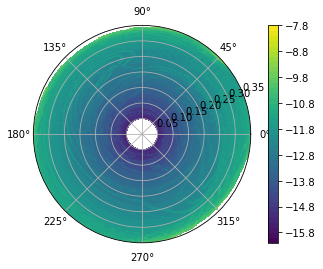

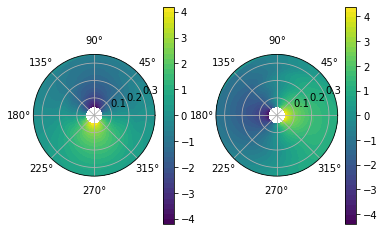

/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


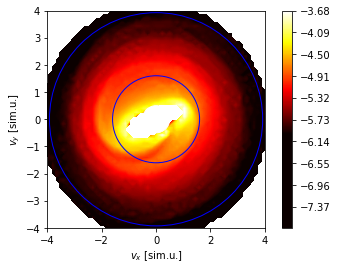

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='polar')

plt.contourf(data3D.phi, data3D.r, np.log(dS.transpose()), levels=50)#, vmin=1.0e-7, vmax=1.0e-4)
plt.ylim(0., 0.35)
plt.colorbar()

plt.show()
plt.close()

fig = plt.figure()
ax = fig.add_subplot(121,projection='polar')
plt.contourf(data3D.phi, data3D.r, vvx.transpose(), levels=50)#, vmin=1.0e-7, vmax=1.0e-4)
plt.ylim(0., 0.35)
plt.colorbar()
ax = fig.add_subplot(122,projection='polar')
plt.contourf(data3D.phi, data3D.r, vvy.transpose(), levels=50)#, vmin=1.0e-7, vmax=1.0e-4)
plt.ylim(0., 0.35)
plt.colorbar()

plt.show()
plt.close()

fig = plt.figure()

#doppler = np.where((np.log(doppler) < -16.) & (np.invert(np.isnan(doppler))), np.exp(-16.)*np.ones(doppler.shape), doppler)
plt.contourf(vx, vy, np.log10(doppler), levels=500, cmap='hot', vmin=-6.)#, vmin=np.log10(np.exp(-14.)))#, vmin=-12., vmax=-8.)#, vmin=1.0e-7, vmax=1.0e-4)
#plt.ylim(0., 0.3)
plt.gca().add_artist(plt.Circle((0,0), np.sqrt(GM1/0.05), color='b', fill=False))
plt.gca().add_artist(plt.Circle((0,0), np.sqrt(GM1/0.3), color='b', fill=False))
plt.gca().add_artist(plt.Circle((0,0), 0.5, color='white', fill=True))
plt.gca().set_aspect('equal')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
plt.xlabel('$v_x$ [sim.u.]')
plt.ylabel('$v_y$ [sim.u.]')
plt.colorbar()

plt.show()
plt.close()

In [117]:
with open(dataset_pathstem + 'doppler.pkl', 'wb') as f:
    pkl.dump((vx, vy, doppler), f)